# Feature Selection

In [82]:
%load_ext autoreload
%autoreload 2

# Standard imports
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import pathlib
import json
import sys
import os
import re

sys.path.append("src/")
from utils import compute_group_differences, auc_roc_curve

# Custom imports
from ToolBox.neuro import stats, plot, wrangling

# Define paths
class PATH:
    STUDY = pathlib.Path('.').parent.resolve()
    FIGURES = STUDY.joinpath('figures')
    RESULTS = STUDY.joinpath('results')
    DEMO = STUDY.joinpath('data/raw/CHARM/demographics.tsv')
    CLEAN_NAMES = STUDY.joinpath('data/clean_feature_names.json')
    FEATURES = dict(
        desikan=STUDY.joinpath('data/cntm-features/Desikan86_sift2/features'),
        schaefer=STUDY.joinpath('data/cntm-features/Schaefer220_sift2/features')
    )

# Load dict for clean feature names
with open(PATH.CLEAN_NAMES) as file:
    clean_names = json.load(file)

# Load demographics information
demo = pd.read_csv(PATH.DEMO, sep='\t')

# Define network and nodal-level measures to include
network = ['degree_avg', 'degree_betweenModule_avg', 'degree_withinModule_avg', 
           'degree_interHemisphere_avg', 'density', 'eigenvector_centrality_avg']
nodal = ['degree', 'degree_betweenModule', 'degree_withinModule', 
         'degree_interHemisphere', 'eigenvector_centrality']

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [51]:
# Other imports
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.feature_selection import RFECV
from sklearn.linear_model import Lasso
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC, SVC

## Desikan Connectomes

In [89]:
fpath = str(PATH.FEATURES['desikan'])

# Load network-level features
network_df = wrangling.load_computed_measures(fpath, scale='global')[network]

# Load node-level features
node_df = wrangling.load_computed_measures(fpath, scale='nodal')
node_df = pd.concat([
    pd.DataFrame(v, columns=[f'{k}_{i+1}' for i in range(v.shape[1])]) 
    for k,v in node_df.items() if k in nodal
], axis=1)

# Construct feature matrix
_fdf = pd.concat([network_df, node_df], axis=1)
features = _fdf.columns.to_numpy()
X = _fdf.values

# Construct target vector
le = LabelEncoder().fit(demo['DX'].values)
y = le.transform(demo['DX'].values)

# Create train/validation split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=69)

# Create dict for storing results
selected = dict()

print(f"Data Shape: {X.shape}")

Data Shape: (313, 436)


In [92]:
# FS: LASSO Regression

## Create pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('lasso', Lasso(random_state=69))
])

## Optimize the alpha hyperparameter
### Test values [0.1,10] -  calculate MSE for 5 fold CV
search = GridSearchCV(
    pipeline,
    {'lasso__alpha':np.arange(0.1,10,0.1)},
    cv=5, 
    scoring="roc_auc"
)
search.fit(X_train, y_train);

# Best alpha
print(search.best_params_)

# Compute importance from model coefficients
importance = np.abs(search.best_estimator_.named_steps['lasso'].coef_)
selected['lasso'] = {'features': features[importance != 0],
                     'idx': importance != 0}

if len(selected['lasso']['features']) > 0:
    for f in selected['lasso']['features']:
        print(f"{f}: {importance[features==f].mean()}")
else:
    print("No features selected")

{'lasso__alpha': 0.1}
degree_withinModule_avg: 0.029726364512908443
degree_withinModule_48: 0.013456476430530797


In [96]:
# FS: SVM-RFE

clf = SVC(kernel='linear', random_state=69)
selector = RFECV(clf, step=50, cv=5, scoring="roc_auc", n_jobs=-1)

param_grid = {
    'estimator__C': np.arange(0.1,10,0.1),
}

search = GridSearchCV(
    selector, 
    param_grid=param_grid, 
    cv=5, 
    scoring='roc_auc', 
    verbose=3,
    n_jobs=-1)
search.fit(X_train, y_train)

Fitting 5 folds for each of 99 candidates, totalling 495 fits
[CV 2/5] END ..................estimator__C=0.2;, score=0.337 total time=   2.6s
[CV 4/5] END ..................estimator__C=0.2;, score=0.455 total time=   2.6s
[CV 5/5] END ..................estimator__C=0.1;, score=0.579 total time=   2.6s
[CV 2/5] END ..................estimator__C=0.1;, score=0.372 total time=   2.6s
[CV 4/5] END ..................estimator__C=0.1;, score=0.455 total time=   2.7s
[CV 5/5] END ..................estimator__C=0.2;, score=0.568 total time=   2.6s
[CV 2/5] END ..estimator__C=0.30000000000000004;, score=0.337 total time=   2.6s
[CV 1/5] END ..................estimator__C=0.2;, score=0.522 total time=   2.8s
[CV 1/5] END ..................estimator__C=0.1;, score=0.549 total time=   2.9s
[CV 3/5] END ..................estimator__C=0.2;, score=0.496 total time=   3.0s
[CV 3/5] END ..................estimator__C=0.1;, score=0.587 total time=   3.0s
[CV 1/5] END ..estimator__C=0.30000000000000004

/home/kabil/.anaconda3/envs/neuro/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
20 fits failed out of a total of 495.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
18 fits failed with the following error:
Traceback (most recent call last):
  File "/home/kabil/.anaconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 355, in _score
    y_pred = method_caller(clf, "decision_function", X)
  File "/home/kabil/.anaconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "/home/kabil/.anaconda3/envs/neuro/lib/python3.9/site-packages/sklearn/svm/_base.py", line 756, in 

GridSearchCV(cv=5,
             estimator=RFECV(cv=5,
                             estimator=SVC(kernel='linear', random_state=69),
                             n_jobs=-1, scoring='roc_auc', step=50),
             n_jobs=-1,
             param_grid={'estimator__C': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3,
       1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5, 2.6,
       2.7, 2.8, 2.9, 3. , 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9,
       4. , 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9, 5. , 5.1, 5.2,
       5.3, 5.4, 5.5, 5.6, 5.7, 5.8, 5.9, 6. , 6.1, 6.2, 6.3, 6.4, 6.5,
       6.6, 6.7, 6.8, 6.9, 7. , 7.1, 7.2, 7.3, 7.4, 7.5, 7.6, 7.7, 7.8,
       7.9, 8. , 8.1, 8.2, 8.3, 8.4, 8.5, 8.6, 8.7, 8.8, 8.9, 9. , 9.1,
       9.2, 9.3, 9.4, 9.5, 9.6, 9.7, 9.8, 9.9])},
             scoring='roc_auc', verbose=3)

In [97]:
C = search.best_params_['estimator__C']
print(search.best_params_)

{'estimator__C': 0.30000000000000004}


In [101]:
selected['svm-rfe'] = {'features': features[search.best_estimator_.get_support()],
                       'idx': search.best_estimator_.get_support()}

In [102]:
pd.Series([re.search('.*(?=_\d{1,2})', x)[0] for x in selected['svm-rfe']['features']]).value_counts()

degree_interHemisphere    25
degree_betweenModule      23
degree                    22
degree_withinModule       16
dtype: int64

### ROC Curves

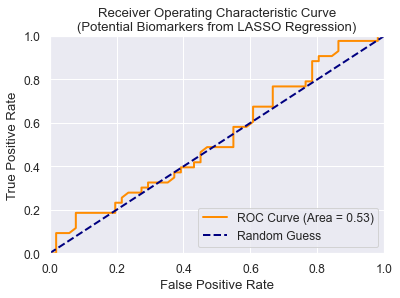

In [173]:
sns.set(font_scale=1.1)

# LASSO Features
I = selected['lasso']['idx']
clf = Pipeline([
    ('scale', StandardScaler()),
    ('svm', LinearSVC(C=C, random_state=69))
])
clf.fit(X_train[:,I], y_train)
auc = auc_roc_curve(
    clf, 
    X_val[:,I], 
    y_val, 
    "(Potential Biomarkers from LASSO Regression)", 
    PATH.FIGURES.joinpath("ROC-lasso.png")
)

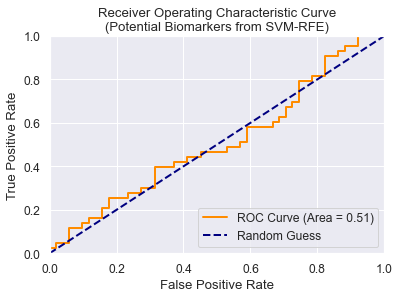

In [174]:
# SVM Features
I = selected['svm-rfe']['idx']
clf = Pipeline([
    ('scale', StandardScaler()),
    ('svm', LinearSVC(C=C, random_state=69))
])
clf.fit(X_train[:,I], y_train)
auc = auc_roc_curve(clf, X_val[:,I], y_val, "(Potential Biomarkers from SVM-RFE)", 
                    PATH.FIGURES.joinpath("ROC-svm-rfe.png"))

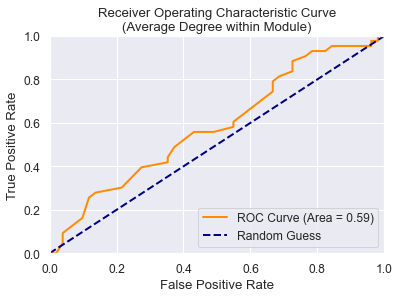

In [175]:
# SVM Features
I = features == 'degree_withinModule_avg'
clf = Pipeline([
    ('scale', StandardScaler()),
    ('svm', LinearSVC(C=C, random_state=69))
])
clf.fit(X_train[:,I], y_train)
auc = auc_roc_curve(clf, X_val[:,I], y_val, "(Average Degree within Module)", 
                    PATH.FIGURES.joinpath("ROC-deg-within-module.png"))

## Correlation map

In [145]:
feature_list = sorted(set(selected['lasso']['features']).union(selected['svm-rfe']['features']))
P = R'.*(?=_)'
colors = {'degree': '#52a869', 'degree_betweenModule': '#d16a60', 
          'degree_withinModule': '#eba067', 
          'degree_interHemisphere': '#7390fa'}
          '': '#eba067', 
          'Interhemispheric Degree': '#7390fa'}
row_colors = [colors[re.search(P, x)[0]] for x in feature_list]

In [144]:
from matplotlib.patches import Patch
corr = pd.concat([demo[['ADOS', 'SCQ', 'IQ']], _fdf[feature_list]], axis=1).corr()
corr_df = corr.loc[feature_list, ['ADOS', 'SCQ', 'IQ']]

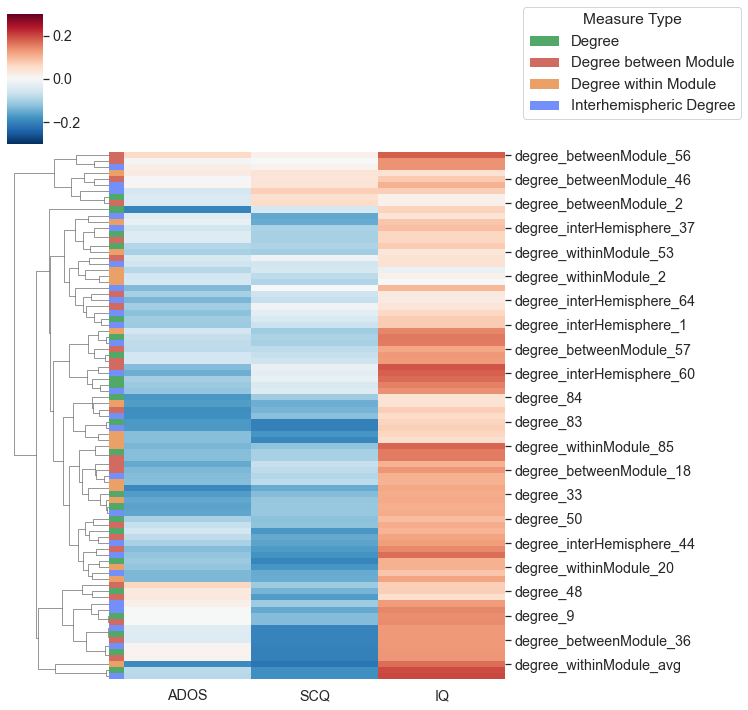

In [169]:
sns.set(font_scale=1.3)
g = sns.clustermap(
    corr_df,
    row_cluster=True,
    col_cluster=False,
    vmin=-0.3,
    vmax=0.3,
    cmap='RdBu_r',
    row_colors=row_colors,
)
handles = [Patch(facecolor=v) for v in colors.values()]
plt.legend(handles, ['Degree', 'Degree between Module', 'Degree within Module',
                     'Interhemispheric Degree'], 
            bbox_to_anchor=(1.05,1),
            bbox_transform=plt.gcf().transFigure,
            loc='upper right',
            title='Measure Type',
            prop={'size': 15},
            facecolor='white',)


## Schaefer Connectomes

In [6]:
fpath = str(PATH.FEATURES['schaefer'])

# Load network-level features
network_df = wrangling.load_computed_measures(fpath, scale='global')[network]

# Load node-level features
node_df = wrangling.load_computed_measures(fpath, scale='nodal')
node_df = pd.concat([
    pd.DataFrame(v, columns=[f'{k}_{i+1}' for i in range(v.shape[1])]) 
    for k,v in node_df.items() if k in nodal
], axis=1)

# Construct feature matrix
_fdf = pd.concat([network_df, node_df], axis=1)
features = _fdf.columns.to_numpy()
X = _fdf.values

# Construct target vector
_y = demo.query("Subject != 'R0083_V0168'")['DX']
le = LabelEncoder().fit(_y.values)
y = le.transform(_y.values)

# Create train/validation split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=69)

# Create dict for storing results
selected = dict()

print(f"Data Shape: {X.shape}")

Data Shape: (312, 1106)


In [8]:
# FS: LASSO Regression

## Create pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('lasso', Lasso(random_state=69))
])

## Optimize the alpha hyperparameter
### Test values [0.1,10] -  calculate MSE for 5 fold CV
search = GridSearchCV(
    pipeline,
    {'lasso__alpha':np.arange(0.1,10,0.1)},
    cv=5, 
    scoring="neg_mean_squared_error"
)
search.fit(X_train, y_train);

# Best alpha
print(search.best_params_)

# Compute importance from model coefficients
importance = np.abs(search.best_estimator_.named_steps['lasso'].coef_)
selected['lasso'] = features[importance != 0]

if len(selected['lasso']) > 0:
    for f in selected['lasso']:
        print(f"{f}: {importance[features==f].mean()}")
else:
    print("No features selected")

{'lasso__alpha': 0.2}
No features selected
